In [28]:
import pandas as pd

In [29]:
# import dataset
df = pd.read_csv(r'C:\Users\kettin\Documents\Lomba\GEMASTIKSciPaper\Dataset\ENSO_dataset_balanced.csv')
print(df.head())

     0         1    2    3    4    5         6         7         8         9  \
0  0.0  0.923388  0.0  0.0  0.0  0.0  2.990105  0.017291  1.682632  4.534331   
1  0.0  1.929875  0.0  0.0  0.0  0.0  5.562883  0.777918  0.464271  5.591380   
2  0.0  0.543871  0.0  0.0  0.0  0.0  3.117626  1.129129  0.000000  6.814785   
3  0.0  2.290855  0.0  0.0  0.0  0.0  1.345732  0.800221  0.000000  6.536081   
4  0.0  4.255888  0.0  0.0  0.0  0.0  0.000000  0.707398  0.000000  7.896858   

   ...       119  120  121  122  123  124       125       126  127  NINO3.4  
0  ...  0.155618  0.0  0.0  0.0  0.0  0.0  6.695034  1.521119  0.0    -1.55  
1  ...  1.411000  0.0  0.0  0.0  0.0  0.0  6.529056  2.613518  0.0    -1.78  
2  ...  1.029515  0.0  0.0  0.0  0.0  0.0  5.309260  2.167389  0.0    -1.38  
3  ...  1.345663  0.0  0.0  0.0  0.0  0.0  4.031511  2.411777  0.0    -1.90  
4  ...  2.738996  0.0  0.0  0.0  0.0  0.0  1.775552  4.273332  0.0    -1.74  

[5 rows x 129 columns]


In [30]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Pisahkan fitur dan target dari df
X = df.drop(columns=['NINO3.4']).values  # semua kolom kecuali target
y = df['NINO3.4'].values  # target tetap apa adanya

# Normalisasi fitur
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Gabung kembali jadi DataFrame
df = pd.DataFrame(X_scaled, columns=df.columns[:-1])  # fitur dengan nama kolom aslinya
df['NINO3.4'] = y  # target tetap sama

print("Normalisasi selesai. Fitur sekarang 0–1, target tetap asli.")
print(f"Ukuran dataset: {df.shape[0]} sampel, {df.shape[1]-1} fitur + 1 target (NINO3.4)")


Normalisasi selesai. Fitur sekarang 0–1, target tetap asli.
Ukuran dataset: 1221 sampel, 128 fitur + 1 target (NINO3.4)


In [31]:
print(df.head())

     0         1    2    3    4    5         6         7         8         9  \
0  0.0  0.088295  0.0  0.0  0.0  0.0  0.227698  0.001255  0.197671  0.335540   
1  0.0  0.184535  0.0  0.0  0.0  0.0  0.423616  0.056479  0.054541  0.413761   
2  0.0  0.052005  0.0  0.0  0.0  0.0  0.237408  0.081978  0.000000  0.504293   
3  0.0  0.219052  0.0  0.0  0.0  0.0  0.102478  0.058099  0.000000  0.483669   
4  0.0  0.406950  0.0  0.0  0.0  0.0  0.000000  0.051359  0.000000  0.584366   

   ...       119  120  121  122  123  124       125       126  127  NINO3.4  
0  ...  0.010775  0.0  0.0  0.0  0.0  0.0  0.557715  0.144249  0.0    -1.55  
1  ...  0.097702  0.0  0.0  0.0  0.0  0.0  0.543889  0.247843  0.0    -1.78  
2  ...  0.071287  0.0  0.0  0.0  0.0  0.0  0.442276  0.205536  0.0    -1.38  
3  ...  0.093177  0.0  0.0  0.0  0.0  0.0  0.335836  0.228711  0.0    -1.90  
4  ...  0.189656  0.0  0.0  0.0  0.0  0.0  0.147909  0.405245  0.0    -1.74  

[5 rows x 129 columns]


In [32]:
from sklearn.model_selection import train_test_split

# Pisahkan fitur dan target
X = df.drop(columns=['NINO3.4']).values
y = df['NINO3.4'].values

# Step 1: Split jadi Training (80%) dan Testing (20%)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2
)

# Step 2: Dari Training (80%), ambil 30% jadi Validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.3, random_state=42, shuffle=True
)

# Cek ukuran akhir
print(f"Training: {X_train.shape[0]} sampel")
print(f"Validation: {X_val.shape[0]} sampel")
print(f"Testing: {X_test.shape[0]} sampel")


Training: 683 sampel
Validation: 293 sampel
Testing: 245 sampel


In [33]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np

# Asumsi X_train, X_val, X_test sudah dalam bentuk (samples, timesteps, features)
# Kalau sekarang X-nya masih 2D, kita reshape jadi time series
timesteps = 1  # kalau tiap baris dianggap 1 timestep (static)
features = X_train.shape[1]
X_train_r = X_train.reshape((X_train.shape[0], timesteps, features))
X_val_r = X_val.reshape((X_val.shape[0], timesteps, features))
X_test_r = X_test.reshape((X_test.shape[0], timesteps, features))

# Model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(timesteps, features)),
    Dropout(0.2),  # Bayesian approximation
    LSTM(32),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)  # output regresi
])

# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile
model.compile(optimizer=optimizer, loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

# Callbacks: EarlyStopping + ReduceLROnPlateau
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=5e-4)

# Training
history = model.fit(
    X_train_r, y_train,
    validation_data=(X_val_r, y_val),
    epochs=128,
    batch_size=16,
    callbacks=[early_stop, reduce_lr]
)

# Evaluasi di test set
test_loss, test_rmse = model.evaluate(X_test_r, y_test)
print(f"Test RMSE: {test_rmse:.4f}")


Epoch 1/128


c:\Users\kettin\miniconda3\envs\tf\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 1.2373 - root_mean_squared_error: 1.1119 - val_loss: 1.0872 - val_root_mean_squared_error: 1.0427 - learning_rate: 0.0010
Epoch 2/128
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9844 - root_mean_squared_error: 0.9905 - val_loss: 0.5764 - val_root_mean_squared_error: 0.7592 - learning_rate: 0.0010
Epoch 3/128
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4538 - root_mean_squared_error: 0.6720 - val_loss: 0.4916 - val_root_mean_squared_error: 0.7012 - learning_rate: 0.0010
Epoch 4/128
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4124 - root_mean_squared_error: 0.6420 - val_loss: 0.4722 - val_root_mean_squared_error: 0.6871 - learning_rate: 0.0010
Epoch 5/128
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4045 - root_mean_squared_error: 0.6358 - val_loss: 0.4496 - val_root_mean_squared_error: 0.6705 - learning_rate: 0.0010
Epoch 6/128
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3576 - root_mean_squared_error: 0.5969 - val_

Min: -3.09
Max: 4.47
Mean: 0.04145645713155963
Std Dev: 1.119353546971535


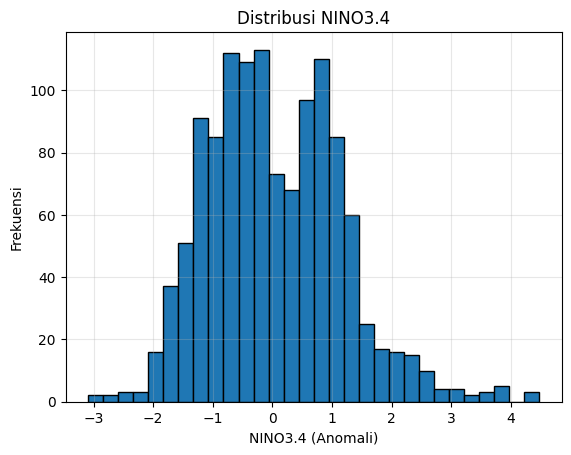

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Statistik dasar
print("Min:", np.min(y))
print("Max:", np.max(y))
print("Mean:", np.mean(y))
print("Std Dev:", np.std(y))

# Histogram distribusi
plt.hist(y, bins=30, edgecolor='black')
plt.title("Distribusi NINO3.4")
plt.xlabel("NINO3.4 (Anomali)")
plt.ylabel("Frekuensi")
plt.grid(alpha=0.3)
plt.show()


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


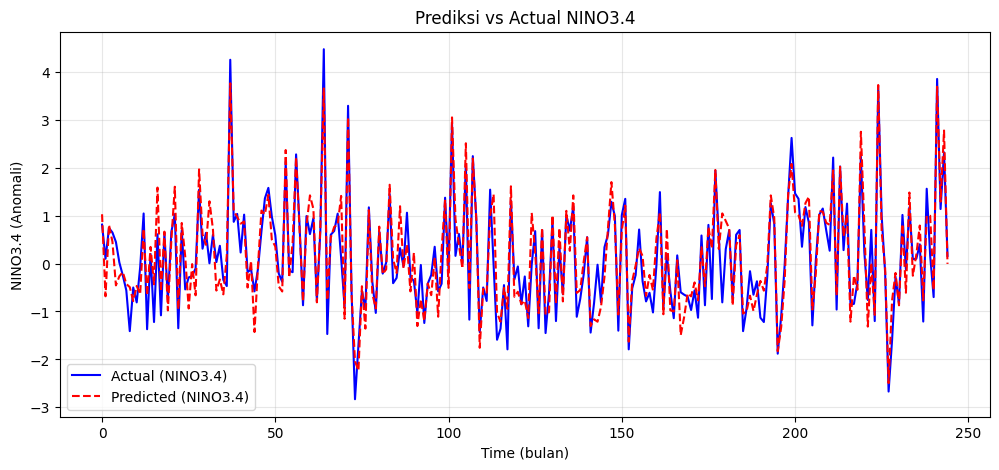

In [35]:
import matplotlib.pyplot as plt

# y_test = target asli di data test
# y_pred = hasil prediksi model (sudah dihitung sebelumnya)
# Prediksi di test set
y_pred = model.predict(X_test_r).flatten()

plt.figure(figsize=(12, 5))
plt.plot(y_test, label='Actual (NINO3.4)', color='blue')
plt.plot(y_pred, label='Predicted (NINO3.4)', color='red', linestyle='--')

plt.title('Prediksi vs Actual NINO3.4')
plt.xlabel('Time (bulan)')
plt.ylabel('NINO3.4 (Anomali)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [36]:
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Hitung RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Normalized RMSE (dibagi dengan rentang data aktual)
nrmse = rmse / (np.max(y_test) - np.min(y_test))

# R²
r2 = r2_score(y_test, y_pred)

print(f"RMSE      : {rmse:.4f}")
print(f"NRMSE     : {nrmse:.4f} (relatif terhadap rentang data)")
print(f"R² Score  : {r2:.4f}")


RMSE      : 0.4507
NRMSE     : 0.0617 (relatif terhadap rentang data)
R² Score  : 0.8409
